<a href="https://colab.research.google.com/github/deividsardinha/CasosCovid/blob/main/TimeSeriesKMeans_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tslearn
!pip install geopandas
!pip install spiderplot

     |████████████████████████████████| 798kB 5.6MB/s 
     |████████████████████████████████| 1.0MB 4.3MB/s 
     |████████████████████████████████| 6.5MB 14.2MB/s 
     |████████████████████████████████| 14.8MB 237kB/s 


Primeiramente, ler o arquivo, usando a função read_csv do panda, carregando em um DataFrame. A coluna ID refere-se ao identificador do bairro de Belo Horizonte. As colunas SG, SRAG e OB são, respectivamente, Síndrome Gripal, Síndrome Respiratória Aguda e Óbitos.

Depois, transformar a coluna DATA do DataFrame em tipo Datetime. 

Em seguida, mostra um resumo estatístico do DataFrame.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import geopandas as gpd
from tslearn.clustering import TimeSeriesKMeans
import seaborn as sns
import spiderplot as sp

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [5]:
# load data in a data frame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Análise Visual/dados_covid_bairro_data_lin.csv', sep=';', encoding='iso-8859-1')

df['DATA'] = pd.to_datetime(df['DATA'])

# some statistics
df.describe()


,ID,SG,SRAG,OB
count,116246.000000,116246.000000,116246.000000,116246.000000
mean,240.122172,0.114929,0.042178,0.012766
std,147.933477,0.447113,0.221674,0.116402
min,1.000000,0.000000,0.000000,0.000000
25%,114.000000,0.000000,0.000000,0.000000
50%,227.500000,0.000000,0.000000,0.000000
75%,361.000000,0.000000,0.000000,0.000000
max,621.000000,14.000000,4.000000,4.000000


A função groupby do DataFrame agrupa os dados por uma coluna. Vamos agrupar os dados por bairro.

A função resample pode ser utilizada para preencher as lacunas faltantes. No caso, utilizamos resample('7D'), para preencher as datas faltantes, com intervalos de sete dias.

Gerar os datasets temporais para cada atributo (SG, SRAG, OB).

In [6]:
sem = df.groupby(['ID',pd.Grouper(freq='7D', key='DATA')]).sum().reset_index()

sem_sg = sem[['ID','DATA','SG']].pivot(index='ID', columns='DATA', values='SG').add_prefix('D').reset_index()
sem_srag = sem[['ID','DATA','SRAG']].pivot(index='ID', columns='DATA', values='SRAG').add_prefix('D').reset_index()
sem_ob = sem[['ID','DATA','OB']].pivot(index='ID', columns='DATA', values='OB').add_prefix('D').reset_index()

In [7]:
sem_sg

DATA,ID,D2020-02-02 00:00:00,D2020-02-09 00:00:00,D2020-02-16 00:00:00,D2020-02-23 00:00:00,D2020-03-01 00:00:00,D2020-03-08 00:00:00,D2020-03-15 00:00:00,D2020-03-22 00:00:00,D2020-03-29 00:00:00,D2020-04-05 00:00:00,D2020-04-12 00:00:00,D2020-04-19 00:00:00,D2020-04-26 00:00:00,D2020-05-03 00:00:00,D2020-05-10 00:00:00,D2020-05-17 00:00:00,D2020-05-24 00:00:00,D2020-05-31 00:00:00,D2020-06-07 00:00:00,D2020-06-14 00:00:00,D2020-06-21 00:00:00,D2020-06-28 00:00:00,D2020-07-05 00:00:00,D2020-07-12 00:00:00,D2020-07-19 00:00:00,D2020-07-26 00:00:00,D2020-08-02 00:00:00,D2020-08-09 00:00:00,D2020-08-16 00:00:00,D2020-08-23 00:00:00,D2020-08-30 00:00:00,D2020-09-06 00:00:00,D2020-09-13 00:00:00,D2020-09-20 00:00:00,D2020-09-27 00:00:00,D2020-10-04 00:00:00,D2020-10-11 00:00:00,D2020-10-18 00:00:00
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,2,1,0,0,1,1,4,1,3,0,0,0,0,0,0
1,2,0,0,0,0,0,2,2,0,0,0,0,0,1,1,0,0,0,3,3,6,3,8,1,0,2,4,2,0,4,3,2,4,0,0,0,0,0,0
2,3,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2,4,3,3,2,4,0,3,2,1,2,2,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,5,2,2,1,3,1,0,1,2,2,0,1,2,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
438,618,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
439,619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0
440,620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
#Identifiação do bairro por ID
bh = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Análise Visual/BAIRRO/BAIRRO.shp",  encoding = 'utf-8')
bairro_id = bh[["ID", "NOME"]]
bairro_id.head()

,ID,NOME
0,264,Corumbiara
1,507,Vila Betânia
2,510,Ambrosina
3,619,Antônio Ribeiro de Abreu
4,194,Vista Alegre


In [9]:
X_sg = sem_sg.iloc[:, 1:].values # dataset de SG
maxsg = np.amax(X_sg)

X_srag = sem_srag.iloc[:, 1:].values # dataset de SRAG
maxsrag = np.amax(X_srag)

X_ob = sem_ob.iloc[:, 1:].values # dataset de OB
maxob = np.amax(X_ob)

sz = X_sg.shape[1]

In [10]:
seed = 0
classes = 6

km = TimeSeriesKMeans(n_clusters=classes, verbose=False, random_state=seed)

y_sg = km.fit_predict(X_sg)
sem_sg['CLASSE'] = y_sg
cc_sg = km.cluster_centers_
unique, counts = np.unique(y_sg, return_counts=True)
c_sg = dict(zip(unique, counts))

y_srag = km.fit_predict(X_srag)
sem_srag['CLASSE'] = y_srag
cc_srag = km.cluster_centers_
unique, counts = np.unique(y_srag, return_counts=True)
c_srag = dict(zip(unique, counts))

y_ob = km.fit_predict(X_ob)
sem_ob['CLASSE'] = y_ob
cc_ob = km.cluster_centers_
unique, counts = np.unique(y_ob, return_counts=True)
c_ob = dict(zip(unique, counts))


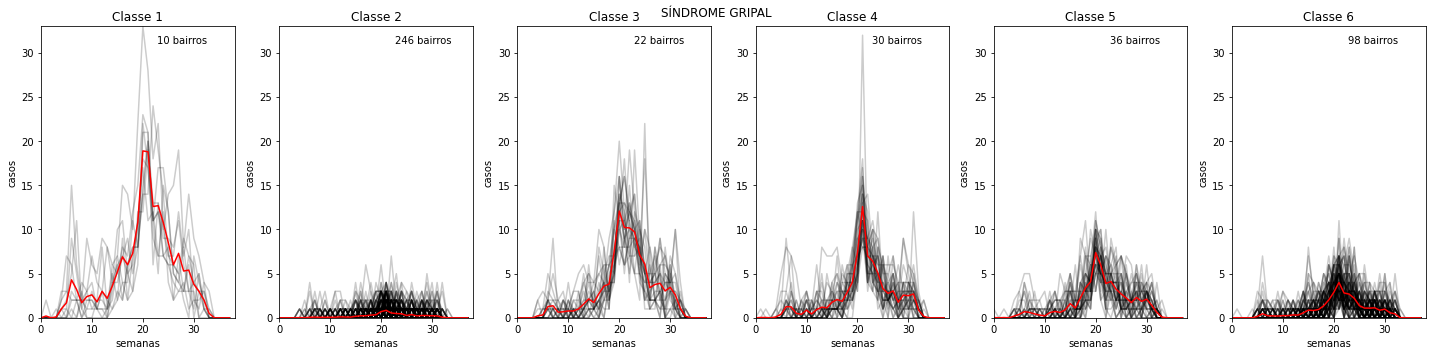

In [11]:
#SÍNDROME GRIPAL
x = 0
plt.figure(figsize=(20,5))
plt.suptitle('SÍNDROME GRIPAL')
for yi in range(classes):
    plt.subplot(1, classes, yi + 1 + x)
    for xx in X_sg[y_sg == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(cc_sg[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, maxsg)
    plt.xlabel('semanas')
    plt.ylabel('casos')
    plt.text(0.60, 0.94,'%d bairros' % c_sg[yi],
             transform=plt.gca().transAxes)
    plt.title('Classe %d' % (yi + 1))

plt.tight_layout()
plt.show() 


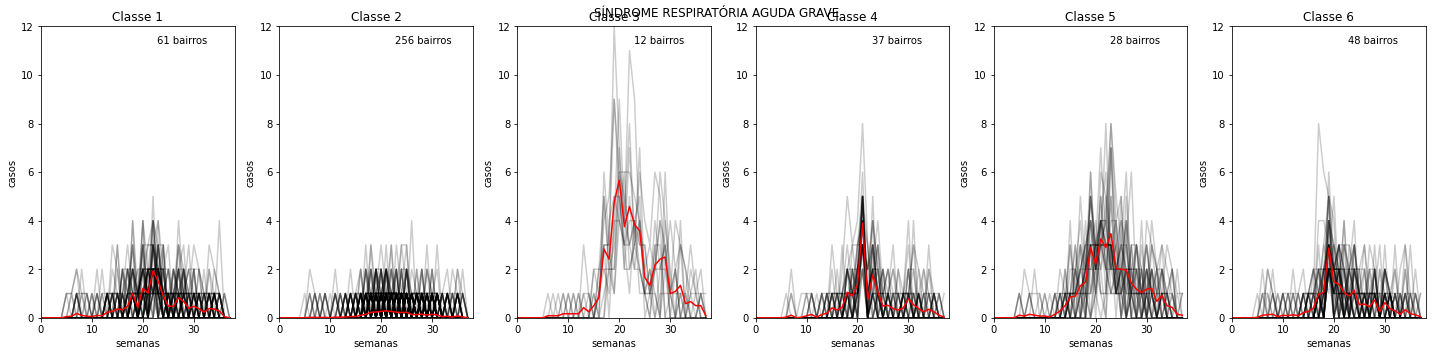

In [12]:
#SÍNDROME RESPIRATÓRIA AGUDA GRAVE
x = 0
plt.figure(figsize=(20,5))
plt.suptitle('SÍNDROME RESPIRATÓRIA AGUDA GRAVE')

for yi in range(classes):
    plt.subplot(1, classes, yi + 1 + x)
    for xx in X_srag[y_srag == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(cc_srag[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, maxsrag)
    plt.xlabel('semanas')
    plt.ylabel('casos')    
    plt.text(0.60, 0.94,'%d bairros' % c_srag[yi],
             transform=plt.gca().transAxes)
    plt.title('Classe %d' % (yi + 1))

plt.tight_layout()
plt.show()     


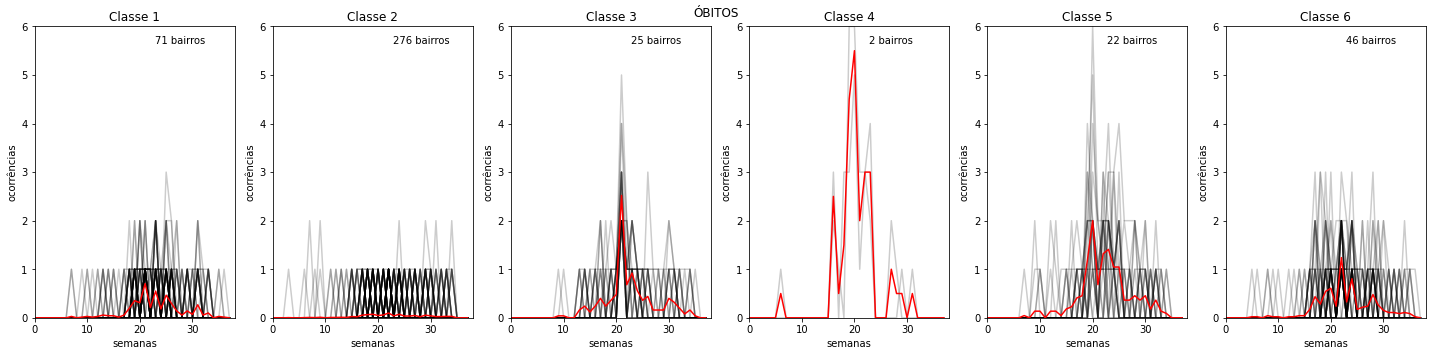

In [13]:
#ÓBITOS
x = 0
plt.figure(figsize=(20,5))
plt.suptitle('ÓBITOS')

for yi in range(classes):
    plt.subplot(1, classes, yi + 1 + x)
    for xx in X_ob[y_ob == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(cc_ob[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, maxob)
    plt.xlabel('semanas')
    plt.ylabel('ocorrências')    
    plt.text(0.60, 0.94,'%d bairros' % c_ob[yi],
             transform=plt.gca().transAxes)
    plt.title('Classe %d' % (yi + 1))

plt.tight_layout()
plt.show() 

In [15]:
#informação dos bairros
censo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Análise Visual/data_bh.csv', sep=',')
censo_join = censo.set_index("Nome_do_bairro").join(bairro_id.set_index("NOME"))
censo_join = censo_join.rename(columns={"COD":"ID"})
censo_join = censo_join[np.isnan(censo_join["ID"])==False]
censo_join.head()

,Cod_setor,TOTAL_FAIXA_ETARIA,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,Cod_setor.1,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,TOTAL_SALARIOS,PRACAS,PARQUES,EMPRESAS OUTROS GROUPOS,EMPRESAS PEQUENO PORTE,ID
Nome_do_bairro,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aarão Reis,1553100303300977,2962,31,301,463,521,528,387,346,385,1553100303300977,44,653,657,229,156,82,10,2,3,794,2962,3.0,0.0,29.0,10.0,1.0
Acaba Mundo,310620005620143,1173,27,237,275,213,185,115,71,50,310620005620143,35,427,156,3,2,1,0,0,0,285,1173,0.0,0.0,4.0,0.0,474.0
Acaiaca,1242480242560419,2565,37,318,415,554,373,407,276,185,1242480242560419,27,459,567,219,158,54,5,1,1,719,2565,0.0,0.0,7.0,8.0,267.0
Ademar Maldonado,1242480102440642,1803,7,162,205,298,326,238,220,347,1242480102440642,11,223,392,219,204,124,21,6,2,432,1803,2.0,0.0,9.0,6.0,227.0
Aeroporto,931860017040198,1325,5,131,151,335,228,183,118,174,931860017040198,4,143,213,117,156,188,27,25,13,303,1325,2.0,0.0,124.0,54.0,203.0


In [16]:
#Agrupando dados, casos COVID com informação dos bairros

weeks = ['D2020-02-02 00:00:00',
       'D2020-02-09 00:00:00', 'D2020-02-16 00:00:00', 'D2020-02-23 00:00:00',
       'D2020-03-01 00:00:00', 'D2020-03-08 00:00:00', 'D2020-03-15 00:00:00',
       'D2020-03-22 00:00:00', 'D2020-03-29 00:00:00', 'D2020-04-05 00:00:00',
       'D2020-04-12 00:00:00', 'D2020-04-19 00:00:00', 'D2020-04-26 00:00:00',
       'D2020-05-03 00:00:00', 'D2020-05-10 00:00:00', 'D2020-05-17 00:00:00',
       'D2020-05-24 00:00:00', 'D2020-05-31 00:00:00', 'D2020-06-07 00:00:00',
       'D2020-06-14 00:00:00', 'D2020-06-21 00:00:00', 'D2020-06-28 00:00:00',
       'D2020-07-05 00:00:00', 'D2020-07-12 00:00:00', 'D2020-07-19 00:00:00',
       'D2020-07-26 00:00:00', 'D2020-08-02 00:00:00', 'D2020-08-09 00:00:00',
       'D2020-08-16 00:00:00', 'D2020-08-23 00:00:00', 'D2020-08-30 00:00:00',
       'D2020-09-06 00:00:00', 'D2020-09-13 00:00:00', 'D2020-09-20 00:00:00',
       'D2020-09-27 00:00:00', 'D2020-10-04 00:00:00', 'D2020-10-11 00:00:00',
       'D2020-10-18 00:00:00']



sem_sg_join = censo_join.set_index("ID").join(sem_sg.set_index("ID"))
sem_sg_join = sem_sg_join[np.isnan(sem_sg_join["D2020-10-18 00:00:00"])== False]  

X_sg = sem_sg_join[weeks].iloc[:, 1:].values # dataset de SG
maxsg = np.amax(X_sg)


sem_srag_join = censo_join.set_index("ID").join(sem_srag.set_index("ID"))
sem_srag_join = sem_srag_join[np.isnan(sem_srag_join["D2020-10-18 00:00:00"])== False] 

X_srag = sem_srag_join[weeks].iloc[:, 1:].values # dataset de SRAG
maxsrag = np.amax(X_srag)


sem_ob_join = censo_join.set_index("ID").join(sem_ob.set_index("ID"))
sem_ob_join = sem_ob_join[np.isnan(sem_ob_join["D2020-10-18 00:00:00"])== False] 

X_ob = sem_ob_join[weeks].iloc[:, 1:].values # dataset de OB
maxob = np.amax(X_ob)

sz = X_sg.shape[1]

# Resultados dos dados agrupados, casos COVID com informação dos bairros

## SÍNDROME GRIPAL

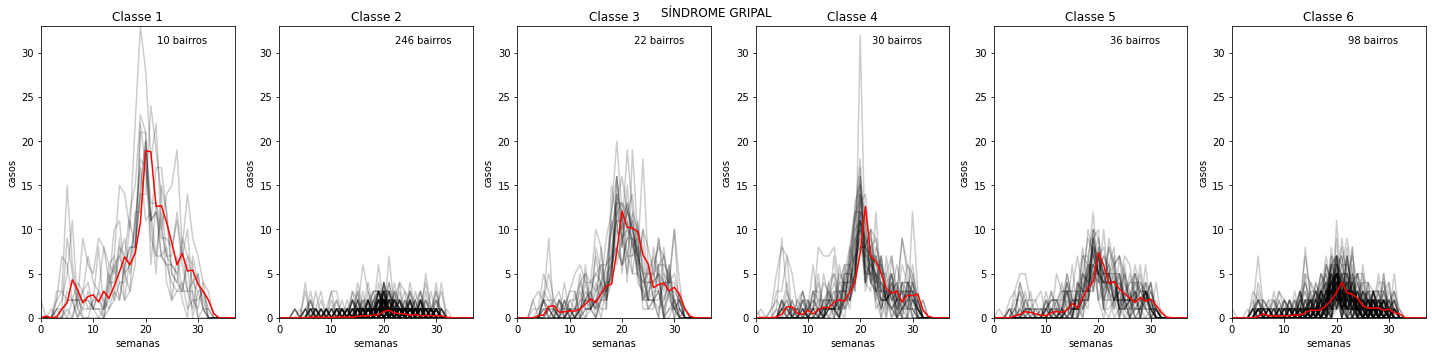

In [17]:
x = 0
plt.figure(figsize=(20,5))
plt.suptitle('SÍNDROME GRIPAL')
for yi in range(classes):
    plt.subplot(1, classes, yi + 1 + x)
    for xx in X_sg[sem_sg_join["CLASSE"] == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(cc_sg[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, maxsg)
    plt.xlabel('semanas')
    plt.ylabel('casos')
    plt.text(0.60, 0.94,'%d bairros' % c_sg[yi],
             transform=plt.gca().transAxes)
    plt.title('Classe %d' % (yi + 1))

plt.tight_layout()
plt.show() 


### Tabelas de medias e desvio padrão das classes segundos os atributos de renda e idade

In [18]:
sem_sg_= sem_sg_join[['ATEMEIOSALARIO', 'DEMEIOA1SALARIO', 'DE1A2SALARIOS',
       'DE2A3SALARIOS', 'DE3A5SALARIOS', 'DE5A10SALARIOS', 'DE10A15SALARIOS',
       'DE15A20SALARIOS', 'MAISDE20SALARIOS', 'SEMSALARIO', 'ABAIXO1ANO', '1A9ANOS', '10A19ANOS',
       '20A29ANOS', '30A39ANOS', '40A49ANOS', '50A59ANOS', 'ACIMA60ANOS', 'CLASSE']]

In [19]:
sem_sg_[sem_sg_["CLASSE"]==0].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,151.000000,2294.900000,3385.90000,1831.500000,2279.700000,2920.800000,828.200000,790.400000,752.500000,5506.400000,237.300000,2030.500000,2772.800000,4445.000000,4069.800000,3313.500000,2784.100000,3356.100000,0.0
std,124.069873,1602.883336,1772.50165,773.496858,970.822566,1592.573515,597.049561,677.235754,839.996197,1642.488708,123.890678,949.122431,961.183969,1011.519978,1569.467978,1138.444772,981.966785,1406.564803,0.0
min,33.000000,610.000000,1398.00000,1027.000000,965.000000,295.000000,18.000000,13.000000,10.000000,3098.000000,70.000000,541.000000,1623.000000,2798.000000,2181.000000,1744.000000,1562.000000,1120.000000,0.0
25%,72.500000,916.500000,1813.75000,1291.750000,1695.500000,2367.750000,516.750000,354.750000,283.250000,4318.000000,136.000000,1281.750000,1980.750000,3711.500000,2798.000000,2571.500000,2344.500000,2473.750000,0.0
50%,83.000000,1694.000000,2766.00000,1698.500000,2096.500000,3157.500000,782.500000,600.500000,390.500000,5514.000000,247.000000,2101.500000,2616.500000,4598.500000,4257.000000,2965.500000,2569.000000,3357.500000,0.0
75%,218.250000,3453.250000,5251.50000,1956.000000,2774.250000,3702.750000,1167.750000,1365.000000,1197.000000,6576.500000,301.250000,2780.250000,3717.000000,4997.500000,4430.750000,3983.250000,2936.250000,4021.750000,0.0
max,354.000000,4799.000000,5637.00000,3433.000000,4057.000000,5460.000000,2023.000000,1835.000000,2533.000000,8217.000000,489.000000,3463.000000,3957.000000,6164.000000,7330.000000,5241.000000,4869.000000,5703.000000,0.0


In [20]:
sem_sg_[sem_sg_["CLASSE"]==1].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.0
mean,33.803468,408.560694,370.572254,108.375723,87.132948,75.046243,16.236994,14.901734,13.676301,544.895954,24.352601,238.450867,332.369942,372.578035,308.473988,257.722543,193.335260,208.722543,1.0
std,34.929607,378.029196,311.945306,119.513125,121.541120,144.841887,38.212935,44.263700,51.624644,425.643331,22.480158,206.443624,275.241314,305.306234,246.817831,210.621515,165.124311,212.671281,0.0
min,0.000000,15.000000,15.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,6.000000,10.000000,15.000000,5.000000,11.000000,3.000000,5.000000,1.0
25%,10.000000,156.000000,122.000000,20.000000,10.000000,3.000000,0.000000,0.000000,0.000000,196.000000,8.000000,97.000000,127.000000,137.000000,111.000000,89.000000,62.000000,46.000000,1.0
50%,23.000000,302.000000,269.000000,59.000000,29.000000,12.000000,1.000000,1.000000,0.000000,436.000000,18.000000,188.000000,263.000000,292.000000,246.000000,190.000000,138.000000,130.000000,1.0
75%,43.000000,518.000000,544.000000,155.000000,125.000000,78.000000,10.000000,4.000000,2.000000,818.000000,32.000000,312.000000,442.000000,537.000000,455.000000,387.000000,285.000000,307.000000,1.0
max,180.000000,2231.000000,1396.000000,533.000000,533.000000,794.000000,226.000000,357.000000,458.000000,2245.000000,135.000000,1339.000000,1695.000000,1657.000000,1237.000000,897.000000,665.000000,888.000000,1.0


In [21]:
sem_sg_[sem_sg_["CLASSE"]==2].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,174.833333,2391.555556,2908.833333,1218.555556,1213.222222,1178.888889,293.444444,277.500000,277.500000,4143.666667,178.500000,1609.388889,2277.388889,2990.222222,2671.277778,2263.333333,1819.777778,2056.000000,2.0
std,142.100731,1467.804251,1096.827470,262.519965,482.797675,1005.646347,369.556367,428.050471,493.051751,1047.282759,75.532034,621.184082,797.904545,644.784739,574.004182,460.683380,504.416093,945.168955,0.0
min,18.000000,403.000000,887.000000,549.000000,470.000000,228.000000,19.000000,7.000000,4.000000,2477.000000,77.000000,629.000000,1067.000000,1924.000000,1645.000000,1299.000000,1085.000000,880.000000,2.0
25%,91.500000,1191.750000,2078.500000,1089.250000,876.750000,494.000000,64.250000,30.750000,16.250000,3470.000000,128.750000,1296.250000,1898.000000,2609.000000,2386.750000,1906.750000,1531.750000,1369.000000,2.0
50%,132.000000,2140.500000,2728.500000,1246.000000,1112.000000,720.500000,112.000000,68.500000,40.500000,4236.500000,169.500000,1538.000000,2075.000000,2897.000000,2635.000000,2297.000000,1804.500000,1900.000000,2.0
75%,202.000000,3282.250000,3626.000000,1400.500000,1527.750000,1720.000000,448.750000,311.500000,204.500000,4443.750000,195.000000,1725.000000,2560.250000,3475.500000,3141.000000,2631.000000,2023.500000,2271.000000,2.0
max,548.000000,5434.000000,4778.000000,1700.000000,2135.000000,3439.000000,1134.000000,1335.000000,1470.000000,5892.000000,387.000000,2972.000000,4147.000000,4038.000000,3730.000000,2983.000000,3129.000000,4656.000000,2.0


In [22]:
sem_sg_[sem_sg_["CLASSE"]==3].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0
mean,156.666667,1982.629630,2389.740741,989.777778,930.962963,851.407407,191.148148,179.259259,193.333333,3303.185185,130.814815,1263.037037,1811.814815,2360.074074,2053.296296,1791.888889,1471.740741,1679.296296,3.0
std,115.257571,1008.482262,852.415418,358.068035,542.565167,897.245368,300.305960,337.967977,415.888576,911.613196,50.036938,490.297044,600.238288,675.756495,579.505347,501.963478,529.875936,795.708480,0.0
min,8.000000,158.000000,465.000000,272.000000,131.000000,37.000000,1.000000,0.000000,1.000000,1278.000000,31.000000,258.000000,600.000000,1221.000000,968.000000,765.000000,681.000000,418.000000,3.0
25%,87.500000,1297.000000,1900.500000,830.500000,614.000000,326.000000,29.000000,12.500000,5.500000,2676.000000,96.000000,950.500000,1481.500000,1844.000000,1749.500000,1504.500000,1169.000000,1243.000000,3.0
50%,155.000000,2043.000000,2421.000000,1058.000000,862.000000,551.000000,70.000000,39.000000,19.000000,3255.000000,128.000000,1300.000000,1731.000000,2304.000000,2074.000000,1769.000000,1370.000000,1374.000000,3.0
75%,184.500000,2664.000000,3051.500000,1180.500000,1013.500000,1217.500000,247.500000,174.500000,128.500000,3861.000000,156.500000,1520.000000,2149.000000,2755.000000,2360.000000,2102.500000,1715.500000,2062.500000,3.0
max,499.000000,4183.000000,4032.000000,1720.000000,2557.000000,4437.000000,1475.000000,1522.000000,1511.000000,4926.000000,253.000000,2453.000000,3329.000000,4303.000000,3287.000000,3033.000000,3443.000000,4254.000000,3.0


In [23]:
sem_sg_[sem_sg_["CLASSE"]==4].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0
mean,106.607143,1511.357143,1865.250000,847.500000,895.892857,924.000000,220.178571,189.607143,168.214286,2665.142857,101.964286,982.428571,1410.750000,1962.892857,1668.142857,1502.571429,1299.571429,1549.821429,4.0
std,119.885235,1152.377164,939.421281,382.486843,519.307112,747.056595,230.924078,260.828500,282.735494,1094.009503,54.887415,552.582049,698.707358,841.583091,690.201941,600.563404,582.946629,771.578855,0.0
min,10.000000,274.000000,550.000000,358.000000,183.000000,48.000000,5.000000,3.000000,0.000000,1054.000000,38.000000,340.000000,546.000000,744.000000,572.000000,607.000000,436.000000,510.000000,4.0
25%,41.250000,783.750000,1279.000000,551.250000,488.000000,292.000000,40.500000,18.750000,10.250000,1969.750000,65.750000,647.250000,956.750000,1362.000000,1176.250000,1046.250000,945.500000,871.750000,4.0
50%,78.000000,1162.500000,1678.000000,786.000000,793.500000,955.000000,164.000000,93.500000,64.000000,2370.000000,93.000000,838.000000,1184.500000,1743.500000,1494.500000,1474.500000,1207.500000,1430.500000,4.0
75%,110.500000,1821.250000,2196.250000,1041.750000,1289.500000,1354.500000,318.750000,217.500000,148.250000,3129.500000,112.500000,1074.250000,1621.500000,2468.000000,1999.500000,1808.500000,1667.750000,2061.500000,4.0
max,540.000000,4949.000000,4495.000000,1961.000000,2091.000000,2849.000000,868.000000,984.000000,1079.000000,5572.000000,242.000000,2579.000000,3369.000000,4149.000000,3410.000000,3357.000000,2892.000000,2997.000000,4.0


In [24]:
sem_sg_[sem_sg_["CLASSE"]==5].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.0
mean,81.564706,1017.223529,1133.764706,433.352941,408.388235,371.541176,84.952941,71.388235,56.717647,1542.294118,66.976471,610.505882,880.141176,1121.541176,953.258824,829.388235,670.823529,746.035294,5.0
std,71.494663,660.437091,562.453419,204.461878,270.223457,374.605493,116.181191,122.412271,114.203621,619.120475,33.844876,307.316365,410.148148,435.655433,362.639994,322.539628,283.806028,405.706892,0.0
min,4.000000,116.000000,224.000000,79.000000,24.000000,6.000000,0.000000,0.000000,0.000000,432.000000,11.000000,163.000000,250.000000,285.000000,307.000000,267.000000,231.000000,168.000000,5.0
25%,28.000000,490.000000,609.000000,269.000000,200.000000,80.000000,9.000000,4.000000,2.000000,1039.000000,43.000000,384.000000,547.000000,761.000000,637.000000,567.000000,474.000000,438.000000,5.0
50%,61.000000,875.000000,988.000000,426.000000,374.000000,209.000000,27.000000,17.000000,9.000000,1452.000000,63.000000,512.000000,765.000000,1122.000000,931.000000,797.000000,623.000000,715.000000,5.0
75%,115.000000,1452.000000,1597.000000,558.000000,577.000000,654.000000,108.000000,72.000000,52.000000,1896.000000,86.000000,762.000000,1148.000000,1397.000000,1176.000000,1018.000000,857.000000,1013.000000,5.0
max,371.000000,3030.000000,2564.000000,972.000000,1124.000000,1603.000000,512.000000,583.000000,606.000000,3079.000000,211.000000,1678.000000,2258.000000,2127.000000,1843.000000,1559.000000,1386.000000,1911.000000,5.0


### Informação de faixas de renda

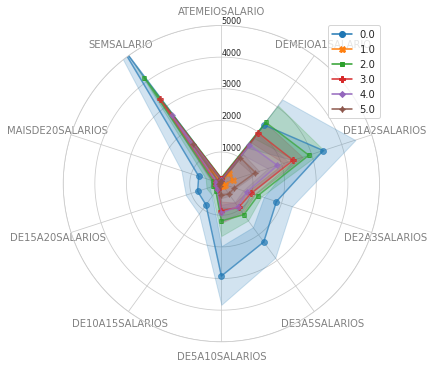

In [25]:
#informação de faixas de renda
sem_sg_join_ = sem_sg_join[['ATEMEIOSALARIO', 'DEMEIOA1SALARIO', 'DE1A2SALARIOS',
       'DE2A3SALARIOS', 'DE3A5SALARIOS', 'DE5A10SALARIOS', 'DE10A15SALARIOS',
       'DE15A20SALARIOS', 'MAISDE20SALARIOS', 'SEMSALARIO', 'CLASSE']]
plt.figure(figsize=(6,6))
xe= pd.melt(sem_sg_join_, id_vars=["CLASSE"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=xe, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,5000])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()


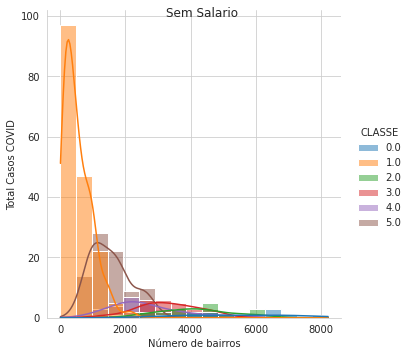

In [26]:
#Sem Salario
sns.displot(sem_sg_join, x="SEMSALARIO", hue="CLASSE", kde=True, palette="tab10")
plt.suptitle('Sem Salario')
plt.ylabel("Total Casos COVID");
plt.xlabel("Número de bairros");

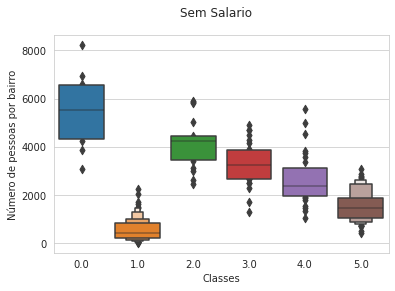

In [27]:
#Sem Salario
sns.boxenplot(data=sem_sg_join, y="SEMSALARIO", x="CLASSE");
plt.suptitle('Sem Salario')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

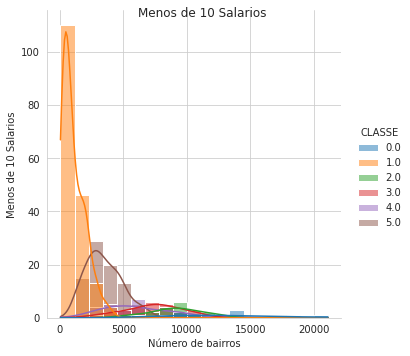

In [28]:
#Menos de 10 Salarios
sem_sg_join["MENOSDE10SALARIOS"] = sem_sg_join[['ATEMEIOSALARIO','DEMEIOA1SALARIO','DE1A2SALARIOS','DE2A3SALARIOS','DE3A5SALARIOS','DE5A10SALARIOS']].sum(axis=1)
sns.displot(sem_sg_join, x="MENOSDE10SALARIOS", hue="CLASSE", kde=True, palette="tab10")
plt.suptitle('Menos de 10 Salarios')
plt.ylabel("Menos de 10 Salarios");
plt.xlabel("Número de bairros");

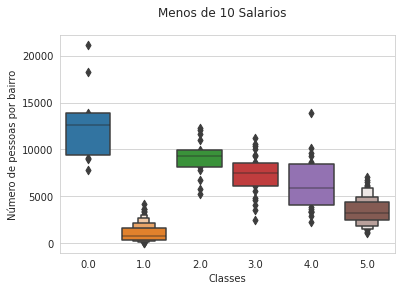

In [29]:
#Menos de 10 Salarios
sns.boxenplot(data=sem_sg_join, y="MENOSDE10SALARIOS", x="CLASSE");
plt.suptitle('Menos de 10 Salarios')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");


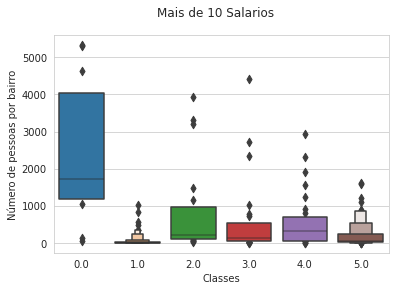

In [30]:
#Mais de 10 Salarios
sem_sg_join["MAISDE10SALARIOS"] = sem_sg_join[['DE10A15SALARIOS','DE15A20SALARIOS','MAISDE20SALARIOS']].sum(axis=1)
sns.boxenplot(data=sem_sg_join, y="MAISDE10SALARIOS", x="CLASSE");
plt.suptitle('Mais de 10 Salarios')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

### Faixas etárias

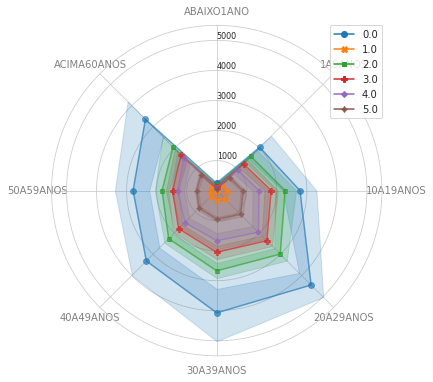

In [31]:
#faixas etárias

sem_sg_join_ = sem_sg_join[['ABAIXO1ANO', '1A9ANOS', '10A19ANOS',
       '20A29ANOS', '30A39ANOS', '40A49ANOS', '50A59ANOS', 'ACIMA60ANOS', 'CLASSE']]
plt.figure(figsize=(6,6))
xe= pd.melt(sem_sg_join_, id_vars=["CLASSE"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=xe, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,5500])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()


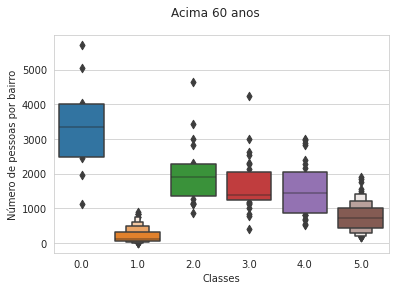

In [32]:
#Acima 60 anos
sns.boxenplot(data=sem_sg_join, y="ACIMA60ANOS", x="CLASSE");
plt.suptitle('Acima 60 anos')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

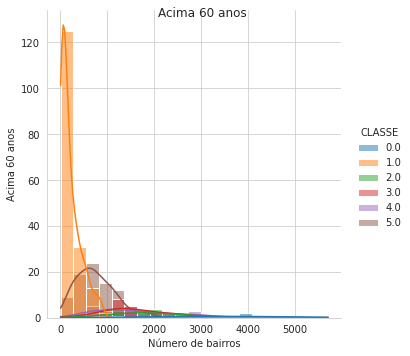

In [33]:
#Acima 60 anos
sns.displot(sem_sg_join, x="ACIMA60ANOS", hue="CLASSE", kde=True, palette="tab10")
plt.suptitle('Acima 60 anos')
plt.ylabel("Acima 60 anos");
plt.xlabel("Número de bairros");

## SÍNDROME RESPIRATÓRIA AGUDA GRAVE

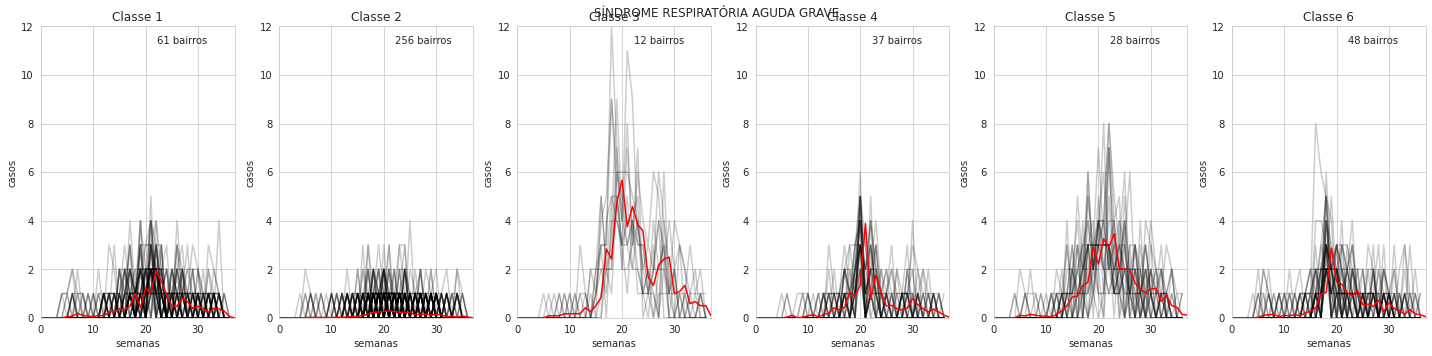

In [34]:
x = 0
plt.figure(figsize=(20,5))
plt.suptitle('SÍNDROME RESPIRATÓRIA AGUDA GRAVE')

for yi in range(classes):
    plt.subplot(1, classes, yi + 1 + x)
    for xx in X_srag[sem_srag_join["CLASSE"]  == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(cc_srag[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, maxsrag)
    plt.xlabel('semanas')
    plt.ylabel('casos')    
    plt.text(0.60, 0.94,'%d bairros' % c_srag[yi],
             transform=plt.gca().transAxes)
    plt.title('Classe %d' % (yi + 1))

plt.tight_layout()
plt.show()     


In [35]:
sem_srag_= sem_srag_join[['ATEMEIOSALARIO', 'DEMEIOA1SALARIO', 'DE1A2SALARIOS',
       'DE2A3SALARIOS', 'DE3A5SALARIOS', 'DE5A10SALARIOS', 'DE10A15SALARIOS',
       'DE15A20SALARIOS', 'MAISDE20SALARIOS', 'SEMSALARIO', 'ABAIXO1ANO', '1A9ANOS', '10A19ANOS',
       '20A29ANOS', '30A39ANOS', '40A49ANOS', '50A59ANOS', 'ACIMA60ANOS', 'CLASSE']]

In [36]:
sem_srag_[sem_srag_["CLASSE"]==0].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.00000,57.000000,57.000000,57.000000,57.0
mean,83.719298,1143.912281,1383.157895,568.122807,558.684211,560.421053,135.947368,138.947368,144.877193,1934.298246,78.315789,722.298246,1051.543860,1403.578947,1195.54386,1063.684211,904.666667,1033.070175,0.0
std,59.145328,641.397311,749.595624,358.112566,469.283655,731.327217,239.274530,305.850829,359.046907,945.679441,39.344249,356.506610,484.822577,714.889276,619.61143,576.056488,568.950454,775.897519,0.0
min,8.000000,158.000000,247.000000,79.000000,24.000000,6.000000,0.000000,0.000000,0.000000,449.000000,13.000000,163.000000,262.000000,222.000000,271.00000,270.000000,146.000000,179.000000,0.0
25%,42.000000,740.000000,710.000000,295.000000,199.000000,126.000000,14.000000,5.000000,3.000000,1085.000000,47.000000,462.000000,676.000000,847.000000,632.00000,581.000000,474.000000,422.000000,0.0
50%,72.000000,999.000000,1357.000000,465.000000,443.000000,273.000000,35.000000,21.000000,12.000000,1780.000000,71.000000,649.000000,1008.000000,1270.000000,1093.00000,1018.000000,824.000000,846.000000,0.0
75%,115.000000,1513.000000,1841.000000,875.000000,790.000000,818.000000,134.000000,83.000000,52.000000,2477.000000,97.000000,911.000000,1234.000000,1809.000000,1510.00000,1426.000000,1266.000000,1353.000000,0.0
max,286.000000,2878.000000,3446.000000,1466.000000,1982.000000,3756.000000,1259.000000,1701.000000,1678.000000,4567.000000,186.000000,1726.000000,2239.000000,3487.000000,2785.00000,2857.000000,3006.000000,3997.000000,0.0


In [37]:
sem_srag_[sem_srag_["CLASSE"]==1].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.0
mean,31.097826,385.864130,402.516304,146.380435,147.461957,150.114130,37.505435,35.000000,30.532609,602.331522,25.320652,240.565217,344.961957,437.125000,352.298913,307.972826,247.836957,278.608696,1.0
std,30.542655,321.667663,334.882607,165.623567,224.779403,302.332938,89.818092,99.619714,103.099448,480.664640,21.477919,188.873324,266.836135,395.538535,295.449075,278.289731,254.948844,338.043421,0.0
min,0.000000,15.000000,15.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,6.000000,10.000000,15.000000,5.000000,11.000000,3.000000,5.000000,1.0
25%,10.000000,166.500000,128.500000,21.000000,10.000000,3.000000,0.000000,0.000000,0.000000,223.750000,8.000000,100.000000,138.750000,141.750000,115.500000,93.500000,65.750000,50.000000,1.0
50%,23.000000,315.000000,307.000000,74.000000,40.000000,16.500000,2.000000,1.000000,0.000000,468.000000,20.500000,205.000000,299.500000,309.500000,261.500000,216.500000,152.500000,145.000000,1.0
75%,41.250000,495.250000,569.250000,222.500000,179.250000,124.750000,21.250000,13.000000,5.250000,849.750000,35.250000,324.500000,472.000000,638.500000,510.500000,442.000000,339.250000,378.250000,1.0
max,180.000000,2231.000000,1496.000000,671.000000,1124.000000,1704.000000,562.000000,772.000000,998.000000,2279.000000,133.000000,1339.000000,1695.000000,2127.000000,1271.000000,1451.000000,1502.000000,2124.000000,1.0


In [38]:
sem_srag_[sem_srag_["CLASSE"]==2].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0
mean,302.000000,3608.090909,3890.727273,1393.818182,1207.454545,1081.818182,244.818182,211.272727,194.454545,5205.363636,224.090909,2108.636364,2981.454545,3638.272727,3168.272727,2733.000000,2228.272727,2590.545455,2.0
std,170.712624,1328.173969,1037.666140,741.450446,1070.336149,1453.180912,418.400482,425.632492,442.633791,1368.124795,83.744199,645.361956,828.785903,1040.910860,1012.015226,911.228292,992.295630,1342.980072,0.0
min,39.000000,965.000000,1980.000000,697.000000,298.000000,121.000000,19.000000,8.000000,3.000000,3374.000000,111.000000,1107.000000,1792.000000,2449.000000,2007.000000,1924.000000,1483.000000,1345.000000,2.0
25%,188.000000,2993.000000,3278.500000,1062.000000,593.500000,250.500000,28.000000,13.500000,9.000000,4367.000000,163.000000,1599.500000,2349.000000,3093.000000,2606.500000,2208.000000,1712.500000,1873.500000,2.0
50%,354.000000,3512.000000,3988.000000,1160.000000,798.000000,472.000000,60.000000,25.000000,29.000000,4973.000000,229.000000,2063.000000,2770.000000,3348.000000,2985.000000,2649.000000,1775.000000,2288.000000,2.0
75%,394.000000,4726.000000,4431.000000,1414.000000,1205.000000,832.000000,124.000000,76.000000,58.500000,5862.500000,275.500000,2582.500000,3665.000000,3953.000000,3365.500000,2798.000000,2237.000000,2376.500000,2.0
max,548.000000,5434.000000,5457.000000,3433.000000,4057.000000,4448.000000,1134.000000,1335.000000,1470.000000,8217.000000,387.000000,2972.000000,4147.000000,6164.000000,5596.000000,5241.000000,4869.000000,5703.000000,2.0


In [39]:
sem_srag_[sem_srag_["CLASSE"]==3].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0
mean,88.285714,1166.321429,1423.714286,619.392857,701.464286,846.928571,240.928571,214.678571,192.928571,2161.107143,96.392857,849.357143,1186.250000,1602.857143,1492.964286,1255.392857,996.821429,1121.464286,3.0
std,62.896068,637.782911,634.214466,380.031611,734.080351,1349.468508,481.697610,469.658824,436.339396,1280.705920,84.811922,596.173739,627.184752,1094.132253,1298.763443,943.959366,773.851601,956.232905,0.0
min,14.000000,255.000000,301.000000,48.000000,27.000000,12.000000,0.000000,0.000000,0.000000,352.000000,15.000000,181.000000,256.000000,210.000000,237.000000,160.000000,106.000000,93.000000,3.0
25%,40.750000,624.500000,977.750000,388.250000,255.250000,115.000000,14.000000,5.750000,2.750000,1265.750000,55.750000,483.750000,711.500000,917.250000,906.000000,747.750000,569.500000,528.250000,3.0
50%,76.500000,1109.500000,1496.500000,549.000000,425.000000,265.500000,44.000000,22.500000,11.000000,1910.500000,80.500000,752.000000,1119.000000,1367.500000,1176.500000,970.500000,831.500000,867.500000,3.0
75%,127.500000,1691.500000,1833.500000,778.500000,868.750000,771.250000,166.750000,97.250000,93.500000,2569.750000,104.000000,985.500000,1544.500000,1822.250000,1724.250000,1517.000000,1059.500000,1251.500000,3.0
max,261.000000,2509.000000,2554.000000,1501.000000,2890.000000,5460.000000,2023.000000,1835.000000,1445.000000,6446.000000,489.000000,3463.000000,3330.000000,5125.000000,7330.000000,4971.000000,3443.000000,4254.000000,3.0


In [40]:
sem_srag_[sem_srag_["CLASSE"]==4].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0
mean,203.913043,2762.869565,3225.869565,1362.869565,1281.304348,1074.304348,209.521739,144.434783,100.260870,4255.608696,172.913043,1670.695652,2363.521739,3195.869565,2735.260870,2315.695652,1869.391304,2141.217391,4.0
std,119.633878,1032.073830,956.955889,544.633514,791.923116,922.131249,221.922359,176.119233,123.113849,1119.225493,62.389475,598.186231,679.343190,915.243351,743.305958,644.291890,627.734436,975.108337,0.0
min,72.000000,971.000000,1559.000000,296.000000,131.000000,37.000000,1.000000,2.000000,0.000000,2261.000000,70.000000,541.000000,1129.000000,1511.000000,1377.000000,1534.000000,1122.000000,833.000000,4.0
25%,116.500000,2069.000000,2575.500000,1073.500000,804.500000,335.500000,31.000000,13.000000,8.000000,3627.000000,132.000000,1318.000000,1895.000000,2723.000000,2206.500000,1826.500000,1519.500000,1438.500000,4.0
50%,160.000000,2581.000000,3080.000000,1404.000000,1072.000000,1058.000000,151.000000,81.000000,49.000000,4152.000000,157.000000,1614.000000,2238.000000,3013.000000,2556.000000,2217.000000,1806.000000,1852.000000,4.0
75%,274.500000,3363.000000,3511.000000,1659.500000,1744.000000,1506.000000,255.500000,169.000000,114.000000,4501.500000,216.000000,2121.500000,2781.500000,3637.500000,3135.000000,2469.000000,2061.500000,2765.500000,4.0
max,499.000000,4799.000000,5637.000000,2828.000000,3476.000000,3543.000000,740.000000,578.000000,431.000000,6953.000000,312.000000,2967.000000,3911.000000,5518.000000,4415.000000,4239.000000,3972.000000,5039.000000,4.0


In [41]:
sem_srag_[sem_srag_["CLASSE"]==5].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0
mean,96.710526,1234.131579,1412.815789,603.921053,612.421053,630.631579,158.210526,149.394737,155.631579,2160.236842,95.131579,873.447368,1201.842105,1523.763158,1389.131579,1148.421053,910.605263,1040.342105,5.0
std,70.971600,637.872612,641.913140,384.842992,542.317730,831.680663,273.736721,315.578194,443.359254,956.758617,53.423940,400.279139,495.708476,735.290030,779.090744,612.159255,558.944446,823.653964,0.0
min,2.000000,131.000000,305.000000,79.000000,25.000000,8.000000,0.000000,0.000000,0.000000,811.000000,14.000000,228.000000,393.000000,553.000000,412.000000,353.000000,242.000000,168.000000,5.0
25%,44.750000,766.250000,947.750000,220.000000,202.750000,71.500000,10.250000,4.250000,3.000000,1452.000000,59.750000,603.000000,814.250000,983.000000,866.250000,680.500000,527.750000,556.250000,5.0
50%,81.000000,1116.500000,1376.500000,538.000000,498.500000,374.000000,44.000000,25.000000,14.500000,1945.500000,85.500000,821.000000,1146.000000,1409.000000,1251.500000,979.500000,750.500000,795.000000,5.0
75%,141.500000,1678.500000,1819.250000,977.500000,945.750000,711.250000,172.500000,110.000000,82.500000,2854.500000,120.000000,1132.250000,1470.000000,1974.500000,1852.500000,1529.000000,1187.500000,1184.250000,5.0
max,371.000000,2794.000000,2763.000000,1330.000000,2124.000000,3254.000000,1211.000000,1583.000000,2533.000000,4582.000000,299.000000,2036.000000,2258.000000,3896.000000,4436.000000,2813.000000,2727.000000,4030.000000,5.0


### Informação de faixas de renda

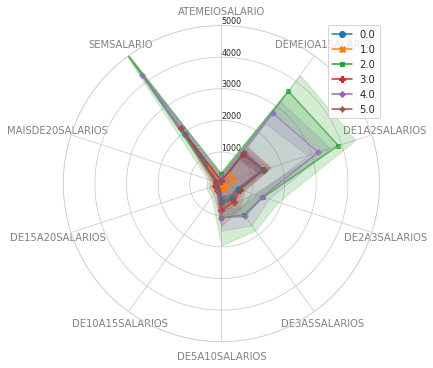

In [42]:
#informação de faixas de renda
sem_srag_join_ = sem_srag_join[['ATEMEIOSALARIO', 'DEMEIOA1SALARIO', 'DE1A2SALARIOS',
       'DE2A3SALARIOS', 'DE3A5SALARIOS', 'DE5A10SALARIOS', 'DE10A15SALARIOS',
       'DE15A20SALARIOS', 'MAISDE20SALARIOS', 'SEMSALARIO', 'CLASSE']]
plt.figure(figsize=(6,6))
xe= pd.melt(sem_srag_join_, id_vars=["CLASSE"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=xe, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,5000])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()


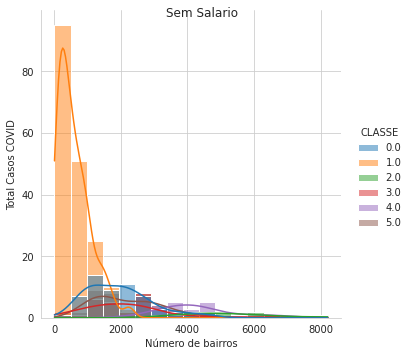

In [43]:
#Sem Salario
sns.displot(sem_srag_join, x="SEMSALARIO", hue="CLASSE", kde=True, palette="tab10")
plt.suptitle('Sem Salario')
plt.ylabel("Total Casos COVID");
plt.xlabel("Número de bairros");

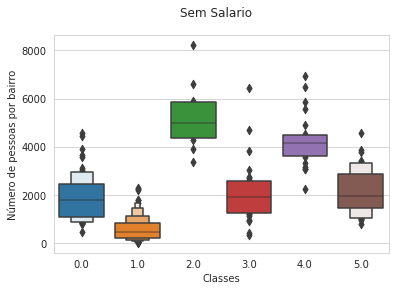

In [44]:
#Sem Salario
sns.boxenplot(data=sem_srag_join, y="SEMSALARIO", x="CLASSE");
plt.suptitle('Sem Salario')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

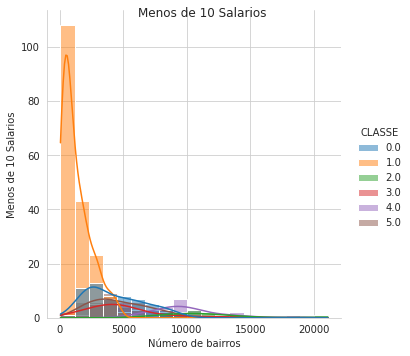

In [45]:
#Menos de 10 Salarios
sem_srag_join["MENOSDE10SALARIOS"] = sem_srag_join[['ATEMEIOSALARIO','DEMEIOA1SALARIO','DE1A2SALARIOS','DE2A3SALARIOS','DE3A5SALARIOS','DE5A10SALARIOS']].sum(axis=1)
sns.displot(sem_srag_join, x="MENOSDE10SALARIOS", hue="CLASSE", kde=True, palette="tab10")
plt.suptitle('Menos de 10 Salarios')
plt.ylabel("Menos de 10 Salarios");
plt.xlabel("Número de bairros");

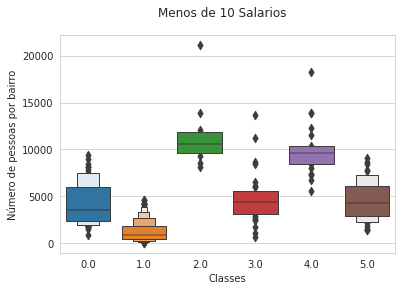

In [ ]:
#Menos de 10 Salarios
sns.boxenplot(data=sem_srag_join, y="MENOSDE10SALARIOS", x="CLASSE");
plt.suptitle('Menos de 10 Salarios')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

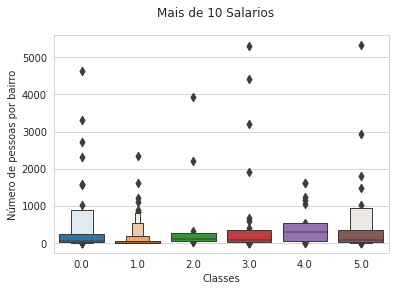

In [ ]:
#Mais de 10 Salarios
sem_srag_join["MAISDE10SALARIOS"] = sem_srag_join[['DE10A15SALARIOS','DE15A20SALARIOS','MAISDE20SALARIOS']].sum(axis=1)
sns.boxenplot(data=sem_srag_join, y="MAISDE10SALARIOS", x="CLASSE");
plt.suptitle('Mais de 10 Salarios')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

### Faixas etárias

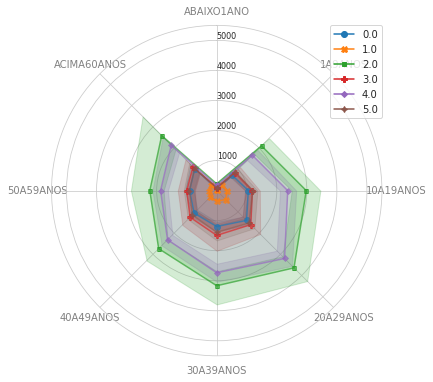

In [ ]:
#faixas etárias
sem_srag_join_ = sem_srag_join[['ABAIXO1ANO', '1A9ANOS', '10A19ANOS',
       '20A29ANOS', '30A39ANOS', '40A49ANOS', '50A59ANOS', 'ACIMA60ANOS', 'CLASSE']]
plt.figure(figsize=(6,6))
xe= pd.melt(sem_srag_join_, id_vars=["CLASSE"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=xe, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,5500])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()


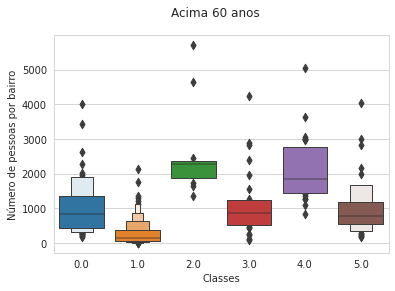

In [ ]:
#Acima 60 anos
sns.boxenplot(data=sem_srag_join, y="ACIMA60ANOS", x="CLASSE");
plt.suptitle('Acima 60 anos')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

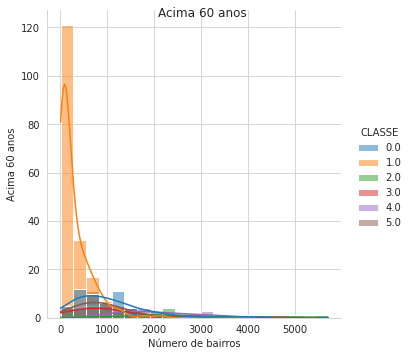

In [ ]:
#Acima 60 anos
sns.displot(sem_srag_join, x="ACIMA60ANOS", hue="CLASSE", kde=True, palette="tab10")
plt.suptitle('Acima 60 anos')
plt.ylabel("Acima 60 anos");
plt.xlabel("Número de bairros");

### Tabelas de medias e desvio padrão das classes segundos os atributos de renda e idade

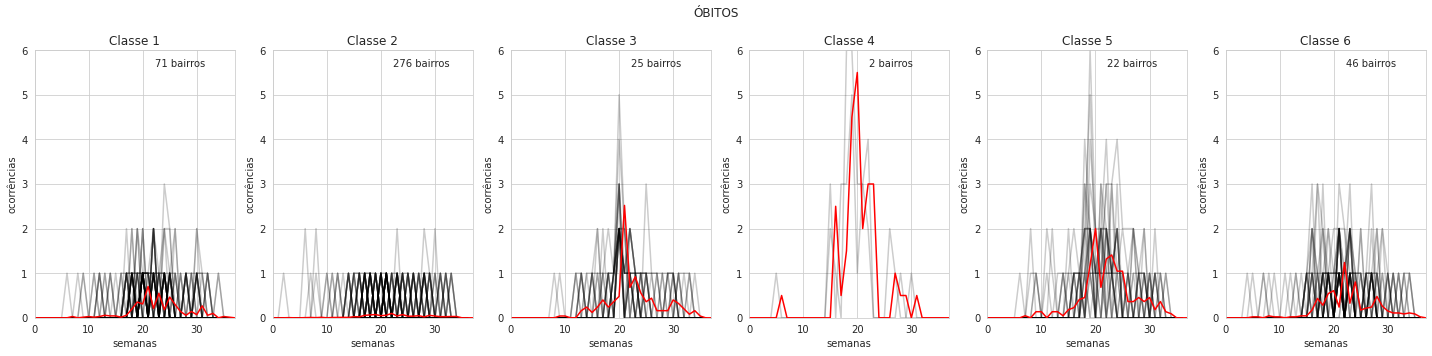

In [ ]:
x = 0
plt.figure(figsize=(20,5))
plt.suptitle('ÓBITOS')

for yi in range(classes):
    plt.subplot(1, classes, yi + 1 + x)
    for xx in X_ob[sem_ob_join["CLASSE"] == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(cc_ob[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, maxob)
    plt.xlabel('semanas')
    plt.ylabel('ocorrências')    
    plt.text(0.60, 0.94,'%d bairros' % c_ob[yi],
             transform=plt.gca().transAxes)
    plt.title('Classe %d' % (yi + 1))

plt.tight_layout()
plt.show() 

### Tabelas de medias e desvio padrão das classes segundos os atributos de renda e idade

In [ ]:
sem_ob_= sem_ob_join[['ATEMEIOSALARIO', 'DEMEIOA1SALARIO', 'DE1A2SALARIOS',
       'DE2A3SALARIOS', 'DE3A5SALARIOS', 'DE5A10SALARIOS', 'DE10A15SALARIOS',
       'DE15A20SALARIOS', 'MAISDE20SALARIOS', 'SEMSALARIO', 'ABAIXO1ANO', '1A9ANOS', '10A19ANOS',
       '20A29ANOS', '30A39ANOS', '40A49ANOS', '50A59ANOS', 'ACIMA60ANOS', 'CLASSE']]

In [ ]:
sem_ob_[sem_ob_["CLASSE"]==0].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,56.000000,56.00000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.0
mean,67.910714,954.00000,1094.339286,468.017857,511.071429,555.053571,141.267857,129.928571,119.464286,1644.946429,68.125000,616.821429,899.446429,1194.767857,1027.714286,917.214286,758.660714,888.196429,0.0
std,48.308206,586.19643,626.266173,334.916298,490.626607,725.048974,215.056144,232.203348,249.824518,842.855847,45.190933,345.115533,436.848837,661.519848,677.201131,561.782123,510.737587,656.704622,0.0
min,5.000000,243.00000,247.000000,18.000000,7.000000,2.000000,0.000000,0.000000,0.000000,352.000000,13.000000,166.000000,256.000000,210.000000,237.000000,160.000000,106.000000,93.000000,0.0
25%,30.750000,511.00000,647.250000,189.500000,92.500000,41.500000,8.250000,2.750000,2.000000,1019.750000,40.500000,383.000000,567.250000,672.500000,564.000000,474.750000,391.750000,406.000000,0.0
50%,53.500000,778.00000,925.500000,413.000000,375.500000,183.000000,33.500000,20.500000,11.000000,1446.500000,57.000000,505.000000,809.000000,1117.500000,943.000000,770.000000,598.000000,701.000000,0.0
75%,83.000000,1258.75000,1567.500000,617.250000,799.250000,783.250000,213.250000,128.000000,92.250000,2126.000000,91.250000,799.250000,1158.500000,1518.250000,1209.500000,1215.750000,1052.000000,1163.750000,0.0
max,206.000000,2878.00000,3446.000000,1288.000000,2124.000000,3254.000000,868.000000,984.000000,1079.000000,3880.000000,299.000000,2036.000000,2049.000000,3137.000000,4436.000000,2813.000000,2489.000000,2872.000000,0.0


In [ ]:
sem_ob_[sem_ob_["CLASSE"]==1].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.0
mean,37.054455,453.480198,490.044554,181.678218,180.782178,193.099010,49.183168,49.727723,49.638614,739.569307,31.663366,300.747525,421.881188,529.376238,448.678218,384.123762,305.569307,334.628713,1.0
std,38.714056,412.716534,454.366469,208.588148,274.732999,420.514551,136.105721,168.176643,197.785408,671.478874,28.624965,261.773402,360.293131,504.869607,433.391830,389.144897,352.508703,464.750193,0.0
min,0.000000,15.000000,15.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,6.000000,10.000000,15.000000,5.000000,11.000000,3.000000,5.000000,1.0
25%,11.000000,170.750000,140.500000,23.500000,12.250000,3.000000,0.000000,0.000000,0.000000,254.500000,10.000000,105.250000,152.500000,152.500000,124.000000,107.250000,71.000000,58.250000,1.0
50%,24.000000,337.000000,363.500000,84.000000,51.000000,25.000000,3.000000,1.000000,1.000000,527.000000,23.500000,237.000000,340.500000,350.500000,300.000000,238.500000,203.000000,171.500000,1.0
75%,49.500000,619.750000,659.250000,282.500000,220.750000,178.750000,27.000000,14.750000,9.000000,1021.000000,45.000000,409.000000,590.750000,756.000000,631.000000,566.250000,442.000000,475.250000,1.0
max,185.000000,2284.000000,2654.000000,1053.000000,1982.000000,3756.000000,1259.000000,1701.000000,1678.000000,4567.000000,136.000000,1407.000000,2025.000000,3487.000000,2785.000000,2857.000000,3006.000000,3997.000000,1.0


In [ ]:
sem_ob_[sem_ob_["CLASSE"]==2].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.0
mean,171.090909,2189.454545,2609.227273,1088.727273,1046.454545,967.909091,213.727273,165.818182,131.909091,3424.909091,137.227273,1311.409091,1897.500000,2611.681818,2195.272727,1894.636364,1597.363636,1812.772727,2.0
std,111.463814,1006.822570,1028.112553,589.940044,885.985420,1185.368615,346.794873,337.324294,306.772431,1341.011342,62.577139,597.630612,728.501054,1229.468851,929.869176,847.008942,846.915723,1203.967684,0.0
min,43.000000,637.000000,988.000000,347.000000,183.000000,59.000000,5.000000,1.000000,0.000000,1145.000000,37.000000,469.000000,621.000000,795.000000,765.000000,700.000000,506.000000,517.000000,2.0
25%,84.250000,1574.750000,1904.000000,564.500000,358.250000,170.750000,23.250000,7.250000,5.250000,2658.750000,88.250000,949.750000,1573.500000,1755.000000,1546.000000,1420.250000,1031.500000,1075.000000,2.0
50%,144.500000,2053.500000,2561.500000,1084.000000,881.500000,455.500000,46.000000,30.500000,12.000000,3501.000000,134.000000,1318.000000,1958.000000,2508.000000,2290.500000,1885.500000,1544.000000,1372.000000,2.0
75%,198.000000,2776.750000,3101.250000,1366.000000,1349.500000,1258.750000,247.000000,183.250000,116.000000,4166.000000,168.500000,1603.500000,2229.500000,3146.500000,2535.500000,2214.250000,1842.750000,2122.000000,2.0
max,424.000000,4516.000000,4959.000000,2828.000000,3476.000000,4437.000000,1475.000000,1522.000000,1425.000000,6476.000000,281.000000,2633.000000,3431.000000,5518.000000,4415.000000,4239.000000,3972.000000,5039.000000,2.0


In [ ]:
sem_ob_[sem_ob_["CLASSE"]==3].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.0
mean,445.500000,4874.000000,4596.500000,1261.500000,631.500000,208.00000,19.000000,10.500000,11.50000,5963.000000,276.000000,2773.000000,3640.000000,3916.00000,3643.500000,2766.000000,1906.000000,2149.500000,3.0
std,133.643182,106.066017,1471.489212,798.323556,471.640223,123.03658,1.414214,3.535534,2.12132,1400.071427,50.911688,274.357431,383.251875,988.53528,837.921536,636.396103,598.212337,580.534667,0.0
min,351.000000,4799.000000,3556.000000,697.000000,298.000000,121.00000,18.000000,8.000000,10.00000,4973.000000,240.000000,2579.000000,3369.000000,3217.00000,3051.000000,2316.000000,1483.000000,1739.000000,3.0
25%,398.250000,4836.500000,4076.250000,979.250000,464.750000,164.50000,18.500000,9.250000,10.75000,5468.000000,258.000000,2676.000000,3504.500000,3566.50000,3347.250000,2541.000000,1694.500000,1944.250000,3.0
50%,445.500000,4874.000000,4596.500000,1261.500000,631.500000,208.00000,19.000000,10.500000,11.50000,5963.000000,276.000000,2773.000000,3640.000000,3916.00000,3643.500000,2766.000000,1906.000000,2149.500000,3.0
75%,492.750000,4911.500000,5116.750000,1543.750000,798.250000,251.50000,19.500000,11.750000,12.25000,6458.000000,294.000000,2870.000000,3775.500000,4265.50000,3939.750000,2991.000000,2117.500000,2354.750000,3.0
max,540.000000,4949.000000,5637.000000,1826.000000,965.000000,295.00000,20.000000,13.000000,13.00000,6953.000000,312.000000,2967.000000,3911.000000,4615.00000,4236.000000,3216.000000,2329.000000,2560.000000,3.0


In [ ]:
sem_ob_[sem_ob_["CLASSE"]==4].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0
mean,204.761905,2619.666667,2823.142857,1023.047619,886.428571,722.428571,146.000000,128.904762,116.285714,3805.809524,163.380952,1518.095238,2175.238095,2701.761905,2274.619048,1940.904762,1586.952381,1797.000000,4.0
std,139.469676,1228.282717,1028.647184,481.553058,620.091894,850.053914,263.453032,302.973911,323.537810,1270.109468,77.530301,645.501581,841.880805,910.254135,789.574093,665.074876,628.056086,976.346455,0.0
min,39.000000,965.000000,1624.000000,195.000000,65.000000,13.000000,1.000000,1.000000,0.000000,2168.000000,95.000000,795.000000,1220.000000,1481.000000,1347.000000,909.000000,606.000000,453.000000,4.0
25%,101.000000,1922.000000,1980.000000,760.000000,470.000000,228.000000,25.000000,19.000000,10.000000,2687.000000,113.000000,1107.000000,1632.000000,1809.000000,1567.000000,1451.000000,1085.000000,1161.000000,4.0
50%,168.000000,2214.000000,2481.000000,1057.000000,763.000000,472.000000,69.000000,33.000000,23.000000,3739.000000,132.000000,1288.000000,1841.000000,2630.000000,2191.000000,1957.000000,1691.000000,1633.000000,4.0
75%,261.000000,3018.000000,3152.000000,1419.000000,1203.000000,702.000000,101.000000,75.000000,51.000000,4443.000000,189.000000,1673.000000,2417.000000,3348.000000,2712.000000,2489.000000,2018.000000,2288.000000,4.0
max,548.000000,5434.000000,5349.000000,1869.000000,2135.000000,3439.000000,1134.000000,1335.000000,1470.000000,6610.000000,387.000000,2972.000000,4147.000000,4603.000000,4278.000000,3074.000000,3129.000000,4656.000000,4.0


In [ ]:
sem_ob_[sem_ob_["CLASSE"]==5].describe()

,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,CLASSE
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0
mean,116.052632,1606.184211,2034.026316,932.105263,963.289474,970.578947,243.894737,210.447368,198.763158,2897.789474,122.789474,1117.342105,1556.815789,2128.342105,1941.736842,1644.263158,1334.184211,1567.789474,5.0
std,91.616400,952.453017,1109.474102,614.024244,825.212631,1243.992757,422.692386,424.472181,493.681615,1671.441847,89.103996,717.134812,868.616416,1270.063103,1393.028738,1098.545591,913.689724,1133.899947,0.0
min,13.000000,249.000000,464.000000,75.000000,18.000000,7.000000,0.000000,0.000000,0.000000,848.000000,15.000000,163.000000,444.000000,536.000000,456.000000,282.000000,189.000000,159.000000,5.0
25%,45.500000,845.000000,1408.250000,486.000000,436.250000,251.000000,26.000000,14.250000,6.000000,1813.500000,66.000000,594.250000,1027.000000,1206.500000,1147.750000,969.000000,647.500000,852.250000,5.0
50%,88.000000,1416.500000,1779.500000,937.500000,761.500000,482.000000,58.000000,30.500000,23.500000,2589.000000,99.000000,959.500000,1342.500000,1873.500000,1566.000000,1428.500000,1197.000000,1236.500000,5.0
75%,143.250000,2064.000000,2503.750000,1199.500000,1367.500000,948.750000,227.750000,128.500000,85.250000,4096.750000,169.500000,1566.250000,2143.500000,2753.500000,2539.750000,2094.000000,1572.000000,1941.750000,5.0
max,376.000000,4062.000000,5457.000000,3433.000000,4057.000000,5460.000000,2023.000000,1835.000000,2533.000000,8217.000000,489.000000,3463.000000,3957.000000,6164.000000,7330.000000,5241.000000,4869.000000,5703.000000,5.0


### Informação de faixas de renda

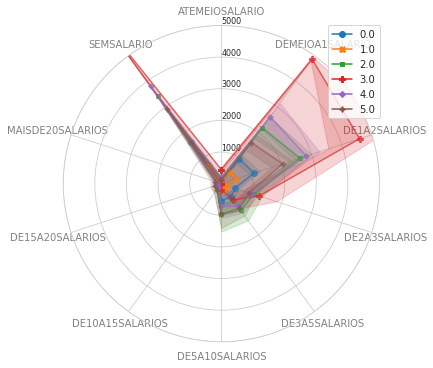

In [ ]:
#informação de faixas de renda
sem_ob_join_ = sem_ob_join[['ATEMEIOSALARIO', 'DEMEIOA1SALARIO', 'DE1A2SALARIOS',
       'DE2A3SALARIOS', 'DE3A5SALARIOS', 'DE5A10SALARIOS', 'DE10A15SALARIOS',
       'DE15A20SALARIOS', 'MAISDE20SALARIOS', 'SEMSALARIO', 'CLASSE']]
plt.figure(figsize=(6,6))
xe= pd.melt(sem_ob_join_, id_vars=["CLASSE"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=xe, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,5000])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()

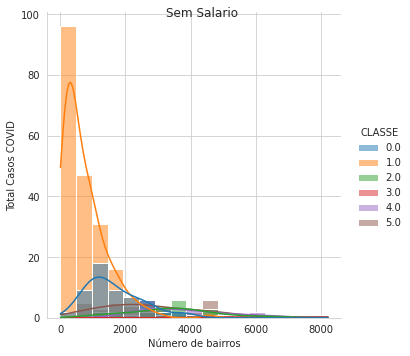

In [ ]:
#Sem Salario
sns.displot(sem_ob_join, x="SEMSALARIO", hue="CLASSE", kde=True, palette="tab10")
plt.suptitle('Sem Salario')
plt.ylabel("Total Casos COVID");
plt.xlabel("Número de bairros");

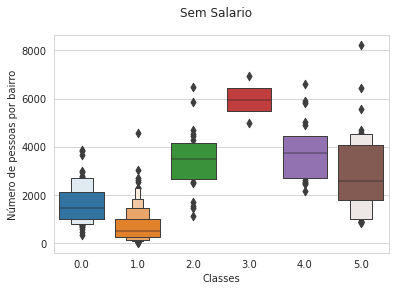

In [ ]:
#Sem Salario
sns.boxenplot(data=sem_ob_join, y="SEMSALARIO", x="CLASSE");
plt.suptitle('Sem Salario')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

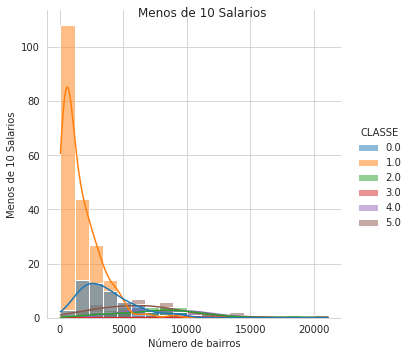

In [ ]:
#Menos de 10 Salarios
sem_ob_join["MENOSDE10SALARIOS"] = sem_ob_join[['ATEMEIOSALARIO','DEMEIOA1SALARIO','DE1A2SALARIOS','DE2A3SALARIOS','DE3A5SALARIOS','DE5A10SALARIOS']].sum(axis=1)
sns.displot(sem_ob_join, x="MENOSDE10SALARIOS", hue="CLASSE", kde=True, palette="tab10")
plt.suptitle('Menos de 10 Salarios')
plt.ylabel("Menos de 10 Salarios");
plt.xlabel("Número de bairros");

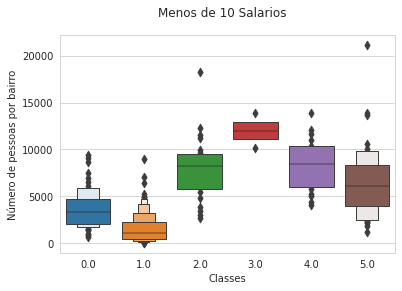

In [ ]:
#Menos de 10 Salarios
sns.boxenplot(data=sem_ob_join, y="MENOSDE10SALARIOS", x="CLASSE");
plt.suptitle('Menos de 10 Salarios')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

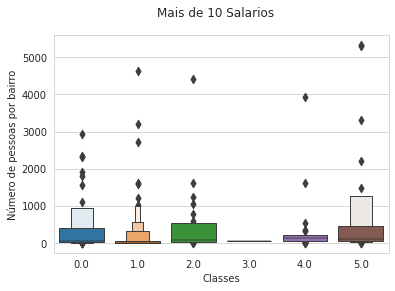

In [ ]:
#Mais de 10 Salarios
sem_ob_join["MAISDE10SALARIOS"] = sem_ob_join[['DE10A15SALARIOS','DE15A20SALARIOS','MAISDE20SALARIOS']].sum(axis=1)
sns.boxenplot(data=sem_ob_join, y="MAISDE10SALARIOS", x="CLASSE");
plt.suptitle('Mais de 10 Salarios')
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

### Faixas etárias

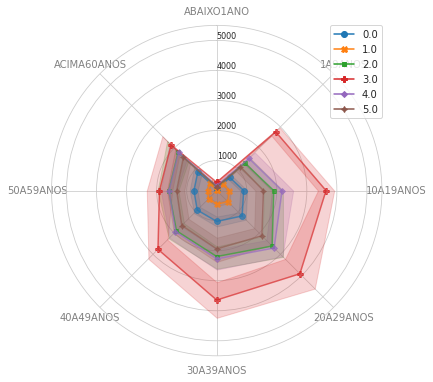

In [ ]:
#faixas etárias

sem_ob_join_ = sem_ob_join[['ABAIXO1ANO', '1A9ANOS', '10A19ANOS',
       '20A29ANOS', '30A39ANOS', '40A49ANOS', '50A59ANOS', 'ACIMA60ANOS', 'CLASSE']]
plt.figure(figsize=(6,6))
xe= pd.melt(sem_ob_join_, id_vars=["CLASSE"], var_name='description')

sns.set_style("whitegrid")
ax = sp.spiderplot(x = "description", y="value", hue="CLASSE", style="CLASSE",
                   data=xe, dashes=False, palette="tab10", rref=0)
ax.set_rlim([0,5500])
ax.legend(loc="upper right",
           bbox_to_anchor=(1., 1.),
           borderaxespad=0.)
plt.tight_layout()
plt.show()


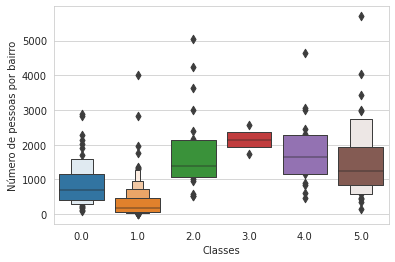

In [ ]:
#Acima 60 anos
sns.boxenplot(data=sem_ob_join, y="ACIMA60ANOS", x="CLASSE");
plt.ylabel("Acima 60 anos");
plt.xlabel("Classes");
plt.ylabel("Número de pessoas por bairro");

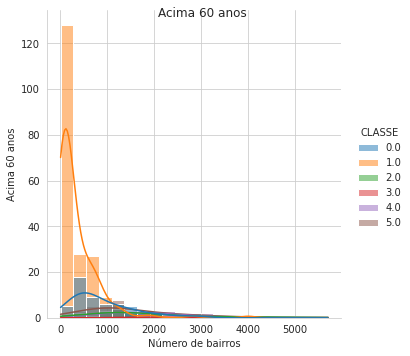

In [ ]:
#Acima 60 anos
sns.displot(sem_ob_join, x="ACIMA60ANOS", hue="CLASSE", kde=True, palette="tab10")
plt.ylabel("Acima 60 anos");
plt.xlabel("Número de bairros");
plt.suptitle('Acima 60 anos');

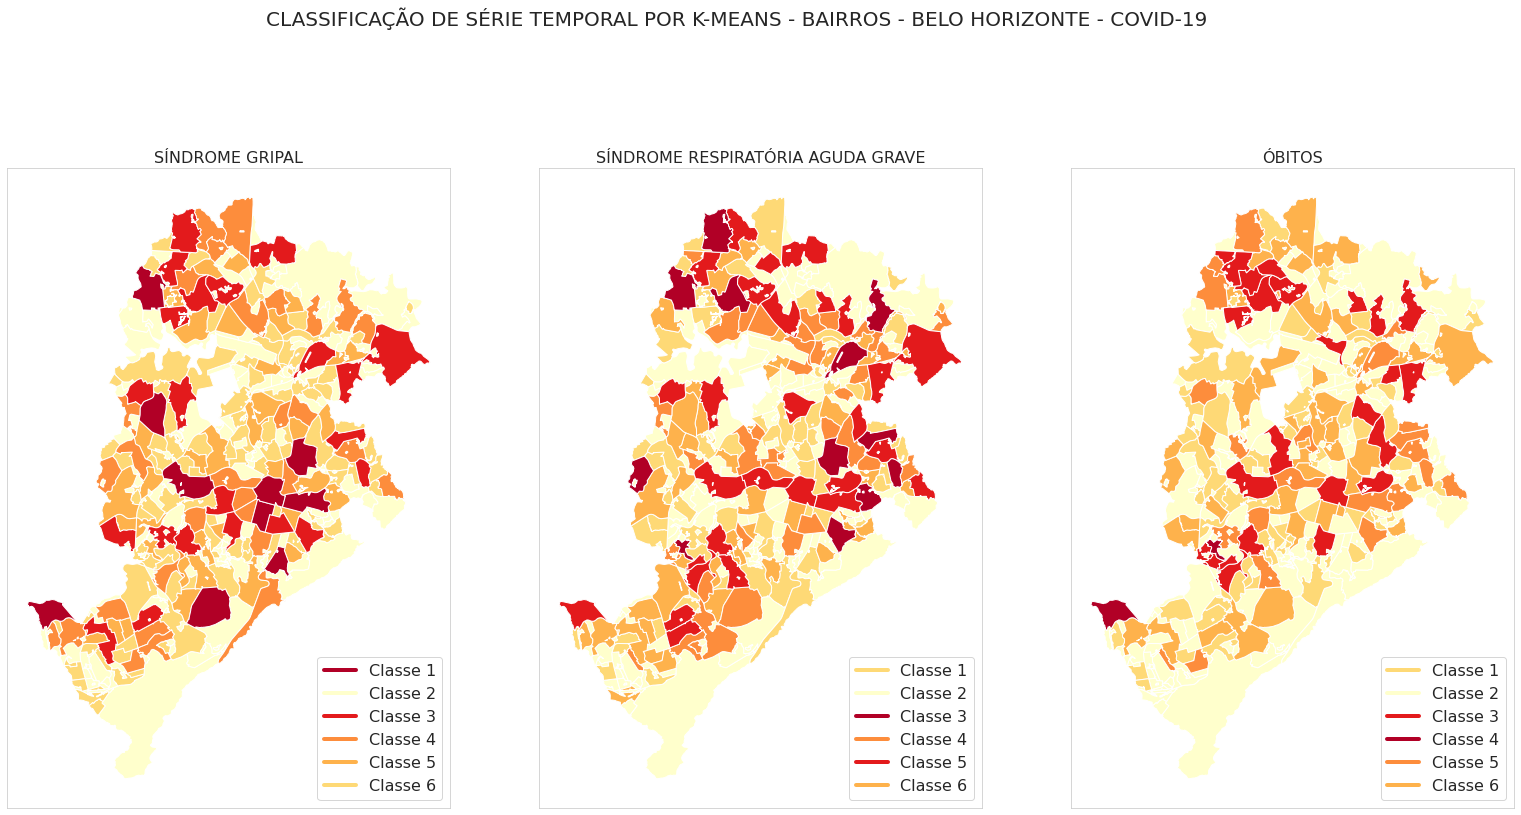

In [ ]:
import geopandas as gpd
from matplotlib.lines import Line2D


bh = gpd.read_file("BAIRRO/BAIRRO.shp", encoding = 'utf-8')

fig, ax = plt.subplots(figsize=(27, 14), ncols=3)

colors = {0:'#FFFFCC', 1:'#FED976', 2:'#FEB24C', 3:'#FD8D3C', 4:'#E31A1C', 5:'#B10026'}

plt.suptitle('CLASSIFICAÇÃO DE SÉRIE TEMPORAL POR K-MEANS - BAIRROS - BELO HORIZONTE - COVID-19', fontsize=20)
colors_sg = {1:colors[0], 5:colors[1], 4:colors[2], 3:colors[3], 2:colors[4], 0:colors[5]}
bh_sg = bh.merge(sem_sg[['ID','CLASSE']], on='ID', how='left')
ax[0].set_title('SÍNDROME GRIPAL', fontsize=16)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
for cl, cor in colors_sg.items():
    bh_sg[bh_sg['CLASSE'] == cl].plot(facecolor=cor, ax=ax[0])
LegendElement = [
                 Line2D([0],[0],color=colors_sg[0],lw=4,label='Classe 1'),
                 Line2D([0],[0],color=colors_sg[1],lw=4,label='Classe 2'),
                 Line2D([0],[0],color=colors_sg[2],lw=4,label='Classe 3'),
                 Line2D([0],[0],color=colors_sg[3],lw=4,label='Classe 4'),
                 Line2D([0],[0],color=colors_sg[4],lw=4,label='Classe 5'),
                 Line2D([0],[0],color=colors_sg[5],lw=4,label='Classe 6')
                ]
ax[0].legend(handles=LegendElement,loc='lower right', fontsize=16)
    
colors_srag = {1:colors[0], 0:colors[1], 5:colors[2], 3:colors[3], 4:colors[4], 2:colors[5]}
bh_srag = bh.merge(sem_srag[['ID','CLASSE']], on='ID', how='left')
ax[1].set_title('SÍNDROME RESPIRATÓRIA AGUDA GRAVE', fontsize=16)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
for cl, cor in colors_srag.items():
    bh_srag[bh_srag['CLASSE'] == cl].plot(facecolor=cor, ax=ax[1])
LegendElement = [
                 Line2D([0],[0],color=colors_srag[0],lw=4,label='Classe 1'),
                 Line2D([0],[0],color=colors_srag[1],lw=4,label='Classe 2'),
                 Line2D([0],[0],color=colors_srag[2],lw=4,label='Classe 3'),
                 Line2D([0],[0],color=colors_srag[3],lw=4,label='Classe 4'),
                 Line2D([0],[0],color=colors_srag[4],lw=4,label='Classe 5'),
                 Line2D([0],[0],color=colors_srag[5],lw=4,label='Classe 6')
                ]
ax[1].legend(handles=LegendElement,loc='lower right', fontsize=16)    
    
colors_ob = {1:colors[0], 0:colors[1], 5:colors[2], 4:colors[3], 2:colors[4], 3:colors[5]}
bh_ob = bh.merge(sem_ob[['ID','CLASSE']], on='ID', how='left')
ax[2].set_title('ÓBITOS', fontsize=16)
ax[2].xaxis.set_visible(False)
ax[2].yaxis.set_visible(False)
for cl, cor in colors_ob.items():
    bh_ob[bh_ob['CLASSE'] == cl].plot(facecolor=cor, ax=ax[2])
LegendElement = [
                 Line2D([0],[0],color=colors_ob[0],lw=4,label='Classe 1'),
                 Line2D([0],[0],color=colors_ob[1],lw=4,label='Classe 2'),
                 Line2D([0],[0],color=colors_ob[2],lw=4,label='Classe 3'),
                 Line2D([0],[0],color=colors_ob[3],lw=4,label='Classe 4'),
                 Line2D([0],[0],color=colors_ob[4],lw=4,label='Classe 5'),
                 Line2D([0],[0],color=colors_ob[5],lw=4,label='Classe 6')
                ]
ax[2].legend(handles=LegendElement,loc='lower right', fontsize=16)    

